# Введение
●	target_sum – прогнозируемая переменная (объем оборота POS-транзакций клиента в последующие 3 месяца). Для одного клиента cl_id строим один прогноз.

In [67]:
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#ser_ts_sum = train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).sum().astype('int64')
#ser_pos_count = train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).count().rename(columns={'target_sum':'count_POS'}).astype('int64')
#ser_notpos_count = train[train['trx_category'] != 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).count().rename(columns={'target_sum':'count_notPOS'}).astype('int64')
#train = train.drop(axis=1, labels='target_sum').join(ser_ts_sum, on=['cl_id', 'year', 'month'], how='left').join(ser_pos_count, on=['cl_id', 'year', 'month'], how='left').join(ser_notpos_count, on=['cl_id', 'year', 'month'], how='left')


'''
[description]
InsertDataFrame - pandas dataframe
ColumnName - name of transforming column
'''
def MakeDateYearMonth(InsertDataFrame, ColumnName):
    df = InsertDataFrame.copy()
    df[ColumnName] = pd.to_datetime(df[ColumnName], dayfirst=True)
    df['year'] = df[ColumnName].dt.year
    df['month'] = df[ColumnName].dt.month
    return df    

'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbysum(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    sdtype = df[TargetColumn].dtype
    ser = df.groupby(by=GroupByList).sum().rename(columns={TargetColumn:TargetName}).astype(sdtype)
    return ser
    
'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbycount(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    ser = df.groupby(by=GroupByList).count().rename(columns={TargetColumn:TargetName}).astype('int64')
    return ser    

'''
[description]
InsertDataFrame - pandas dataframe
SeriesList - list of pandas series
OnJoin - string or list of column name(s)
'''
def DfLeftJoinSer(InsertDataFrame, SeriesList, OnJoin):
    df = InsertDataFrame.copy()
    for i in SeriesList:
        df = df.join(i, on=OnJoin, how='left')
    return df

In [3]:
url_train = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/train.csv'
url_test = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/test.csv'

#train = pd.read_csv(url_train)
#test = pd.read_csv(url_test)

train = pd.read_csv('D:\Зубарев (D)/Git\Machine-learning-course-task/train.csv')
test = pd.read_csv('D:\Зубарев (D)/Git/Machine-learning-course-task/test.csv')

In [4]:
train2 = train.copy()

In [5]:
train = train2.copy()
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   PERIOD        490513 non-null  object 
 1   cl_id         490513 non-null  int64  
 2   MCC           490513 non-null  int64  
 3   channel_type  487603 non-null  object 
 4   currency      490513 non-null  int64  
 5   TRDATETIME    490513 non-null  object 
 6   amount        490513 non-null  float64
 7   trx_category  490513 non-null  object 
 8   target_sum    490513 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 33.7+ MB


# Независимые переменные для модели
год, месяц - сколько берём? надо смотреть сколько есть  
количество POS-транзакций  
количество не-POS-транзакций  
сумма POS-транзакций  
сумма не- POS-транзакций

не забываем нормализацию!!!!!

In [10]:
train[['cl_id', 'target_sum', 'year', 'month']]

,cl_id,target_sum,year,month
0,0,0.0,2017,10
1,0,0.0,2017,10
2,0,0.0,2017,12
3,0,0.0,2017,10
4,0,0.0,2017,10
...,...,...,...,...
490508,10176,405.0,2017,4
490509,10171,0.0,2017,6
490510,10167,280428.2,2017,2
490511,10163,0.0,2017,6


In [11]:
# Входные сырые данные + колонки
train = MakeDateYearMonth(train, 'PERIOD')
group_list = ['cl_id', 'year', 'month']
ser_ts_sum = train[['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).first().astype('float64')
ser_pos_amount_sum = groupbysum(train[train['trx_category'] == 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_pos')
ser_notpos_amount_sum = groupbysum(train[train['trx_category'] != 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_notpos')
ser_pos_count = groupbycount(train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']],
                       group_list,
                       'target_sum',
                       'count_pos')
ser_notpos_count = groupbycount(train[train['trx_category'] != 'POS'][['cl_id', 'target_sum', 'year', 'month']],
                       group_list,
                       'target_sum',
                       'count_notpos')

train = DfLeftJoinSer(train.drop(axis=1, labels=['PERIOD','MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 'target_sum']).drop_duplicates(),
                      [ser_ts_sum, ser_pos_amount_sum, ser_notpos_amount_sum, ser_pos_count, ser_notpos_count],
                      ['cl_id', 'year', 'month'])
train.head()

,cl_id,year,month,target_sum,sum_pos,sum_notpos,count_pos,count_notpos
0,0,2017,10,0.0,7054.00,56562.0,2.0,2.0
2,0,2017,12,0.0,767.00,NaN,1.0,NaN
5,1,2017,10,0.0,11555.00,NaN,24.0,NaN
9,1,2017,7,0.0,3930.26,50000.0,10.0,1.0
10,1,2017,9,0.0,103285.28,95000.0,60.0,2.0


In [12]:
# Через промедуточный датафрейм
# train_transformed
train_tf = pd.DataFrame(columns=['cl_id', 'target_sum'])
for i in train.cl_id.unique():
    train_tf = train_tf.append(train[train['cl_id'] == i][['cl_id', 'target_sum']].iloc[0])
train_tf = train_tf.astype({'cl_id': 'int64'})
    
for mon in range(1,train.groupby('cl_id').count().month.max()+1): # 14
    train_tf[f'_{mon}_sum_pos'] = np.NaN
    train_tf[f'_{mon}_sum_notpos'] = np.NaN
    train_tf[f'_{mon}_count_pos'] = np.NaN
    train_tf[f'_{mon}_count_notpos'] = np.NaN


#train = train.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False])    
#for ind in train_tf.index[:2]:
    #train_tf.loc[ind, '_1_sum_pos'] = 1

train_tf.head()

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,5,326211.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,9,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train = train.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False]) 
for ind in train_tf.index:
    mon = 1
    temp_id = train_tf.loc[ind].cl_id
    for ji in train[train['cl_id'] == temp_id].index:
        train_tf.loc[ind,f'_{mon}_sum_pos'] = train.loc[ji,'sum_pos']
        train_tf.loc[ind,f'_{mon}_sum_notpos'] = train.loc[ji,'sum_notpos']
        train_tf.loc[ind,f'_{mon}_count_pos'] = train.loc[ji,'count_pos']
        train_tf.loc[ind,f'_{mon}_count_notpos'] = train.loc[ji,'count_notpos']
        mon+=1
train_tf.fillna(0, inplace=True)
train_tf.head(15)    

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,0,0.00,767.00,0.00,1.0,0.0,7054.00,56562.00,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.00,11555.00,0.00,24.0,0.0,103285.28,95000.00,60.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,5,326211.75,90924.37,88878.38,30.0,7.0,30119.90,47500.00,28.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,9,0.00,1559.00,250000.00,13.0,3.0,2206.09,182500.00,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,10,0.00,61293.27,43290.00,111.0,12.0,95558.52,829747.88,158.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,11,0.00,6151.05,0.00,22.0,0.0,77543.74,95000.00,88.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,14,187776.76,31197.08,0.00,31.0,0.0,72628.55,45700.00,60.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,20,0.00,70379.64,60000.00,40.0,1.0,77301.36,80000.00,22.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1183,21,0.00,75433.06,47778.00,35.0,5.0,70058.93,20000.00,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1184,22,0.00,511.00,0.00,1.0,0.0,4403.00,5000.00,13.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Анализ данных
какой месяц для модели текущий  
сколько для каждого клиента известно месяцев

In [14]:
# количество уникальных клиентов
print('number of cl_id', len(train.cl_id.unique()), end='\n\n')
print('max count of month', train.groupby('cl_id').count().month.max(), end='\n\n')
print('count of months \n', train.groupby('cl_id').count().year.value_counts(), end='\n\n')
temp_df = train.groupby('cl_id').last()[['year', 'month', 'target_sum']]
temp_df['ym'] = temp_df.apply(lambda row: str(int(row.year))+'-'+str(int(row.month)), axis=1)
print('last month of target_sum > 1 \n', temp_df[temp_df['target_sum'] > 1].ym.value_counts(), end='\n\n' )
print('last month of target_sum < 1 \n', temp_df[temp_df['target_sum'] < 1].ym.value_counts(), end='\n\n' )

number of cl_id 5000

max count of month 14

count of months 
 4     2894
3     1297
2      416
1      217
5      120
6       22
7       12
8        8
9        6
10       4
11       3
14       1
Name: year, dtype: int64

last month of target_sum > 1 
 2016-12    376
2017-7     334
2017-6     329
2017-4     305
2016-11    280
2017-5     274
2017-3     242
2017-2     231
2016-10    100
2017-1      84
2017-8      64
2017-10     38
2017-9      34
2017-11     27
2018-1      16
2018-2      14
2017-12     12
2018-3       6
Name: ym, dtype: int64

last month of target_sum < 1 
 2016-12    410
2016-11    303
2017-4     219
2017-5     203
2017-6     196
2017-2     192
2017-3     191
2017-7     185
2016-10    132
2017-1      69
2017-8      45
2017-9      16
2017-10     16
2017-11     15
2017-12     15
2018-2      11
2018-1       8
2018-3       7
Name: ym, dtype: int64



In [15]:
'''for i in train.cl_id[10:30]:
    fig = plt.figure()
    x = list()
    y = list()
    temp_df = train[train['cl_id'] == i].reset_index(drop=True)
    for ji in temp_df.index:
        j = temp_df.iloc[ji]
        x.append(str(int(j.year))+ '-' + str(int(j.month)))
        y.append(j.pos_sum + j.notpos_sum)
    x.append('target')
    y.append(j.target_sum)
    print(x,y)
    plt.plot(x,y)
    plt.show()
plt.close('all')  
temp_df'''

"for i in train.cl_id[10:30]:\n    fig = plt.figure()\n    x = list()\n    y = list()\n    temp_df = train[train['cl_id'] == i].reset_index(drop=True)\n    for ji in temp_df.index:\n        j = temp_df.iloc[ji]\n        x.append(str(int(j.year))+ '-' + str(int(j.month)))\n        y.append(j.pos_sum + j.notpos_sum)\n    x.append('target')\n    y.append(j.target_sum)\n    print(x,y)\n    plt.plot(x,y)\n    plt.show()\nplt.close('all')  \ntemp_df"

# Формирование выборки

In [203]:
columns_take = ['_1_sum_pos', '_2_sum_pos', '_3_sum_pos', '_4_sum_pos']
columns_drop = ['cl_id', 'target_sum']

X = train_tf[train_tf['target_sum'] != 0].drop(axis=1, labels=['cl_id', 'target_sum'])
#X = train_tf[train_tf['target_sum'] != 0][columns_take]
y = train_tf[train_tf['target_sum'] != 0].target_sum
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [204]:
X.head()

,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,_3_sum_pos,_3_sum_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
109,90924.37,88878.38,30.0,7.0,30119.90,47500.0,28.0,9.0,117748.12,93500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,31197.08,0.00,31.0,0.0,72628.55,45700.0,60.0,2.0,10899.50,144000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1366,1544.00,7700.00,8.0,2.0,2825.30,20600.0,16.0,3.0,5503.50,63200.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1417,3374.77,0.00,4.0,0.0,2110.99,2000.0,3.0,1.0,52700.00,53000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1418,170.00,0.00,1.0,0.0,666.00,1035000.0,2.0,1.0,10564.00,425000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
y.head()

109     326211.75
970     187776.76
1366      3888.00
1417      1260.64
1418       144.61
Name: target_sum, dtype: float64

In [206]:
train_tf.head()

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,0,0.00,767.00,0.00,1.0,0.0,7054.00,56562.00,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.00,11555.00,0.00,24.0,0.0,103285.28,95000.00,60.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,5,326211.75,90924.37,88878.38,30.0,7.0,30119.90,47500.00,28.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,9,0.00,1559.00,250000.00,13.0,3.0,2206.09,182500.00,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,10,0.00,61293.27,43290.00,111.0,12.0,95558.52,829747.88,158.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Модель

In [207]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg_pred = reg.predict(X_test)
reg.score(X_test,y_test.to_numpy())
#reg.score(X_test,y_test)

-3.7274120127359467

In [208]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
RFR_pred = RFR.predict(X_test)
RFR.score(X_test,y_test.to_numpy())

-15.224661607403906

In [209]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(random_state=0, max_depth=3).fit(X_train, y_train)
GBR_pred = GBR.predict(X_test)
GBR.score(X_test,y_test.to_numpy())

-106.05897718348297

In [210]:
results = pd.DataFrame(data={'y_true':y_test.to_numpy(), 'reg':reg_pred, 'RFR':RFR_pred, 'GBR':GBR_pred}, dtype='float64')

(-300000, 300000)

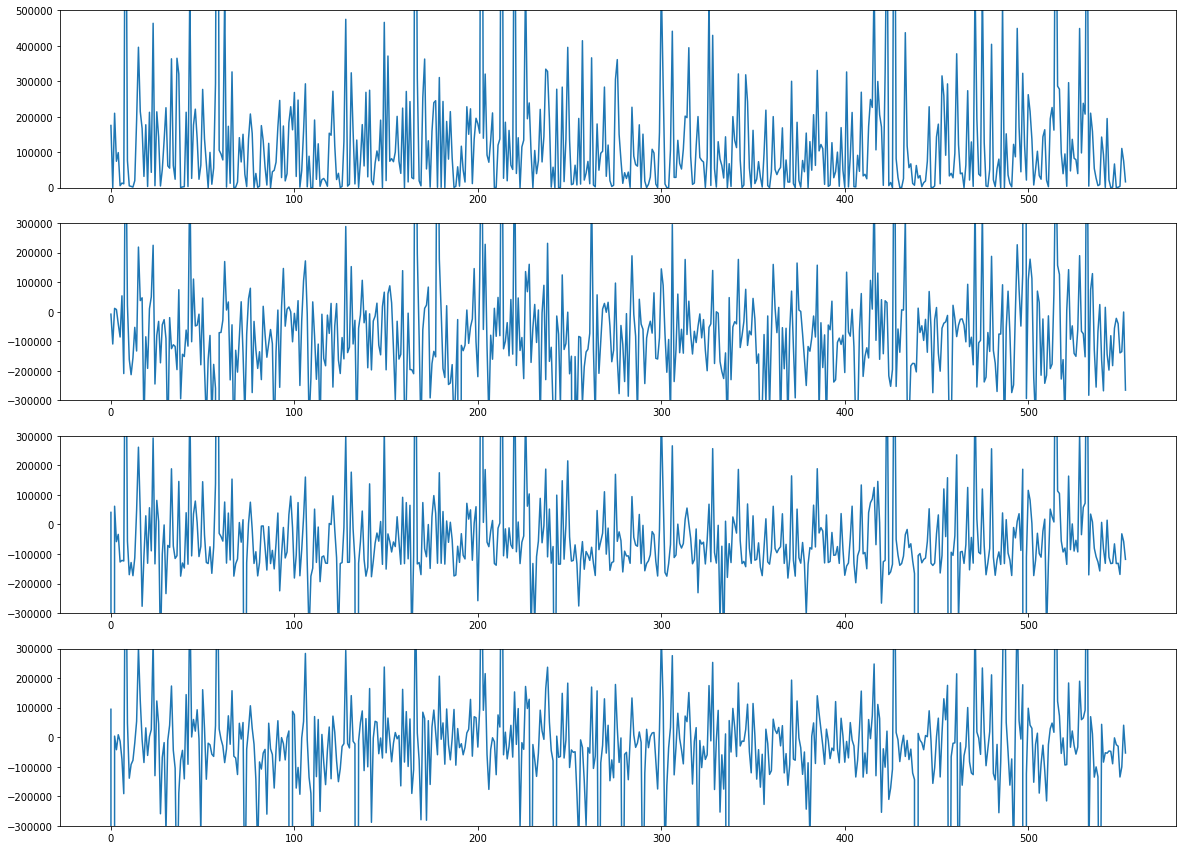

In [211]:
fig, ax = plt.subplots(4,1, figsize = (20,15)) #, sharey=True
ax[0].plot(results.index, results.y_true)
ax[1].plot(results.index, results.y_true-results.reg)
ax[2].plot(results.index, results.y_true-results.RFR)
ax[3].plot(results.index, results.y_true-results.GBR)
ax[0].set_ylim([0,500000])
ax[1].set_ylim([-300000,300000])
ax[2].set_ylim([-300000,300000])
ax[3].set_ylim([-300000,300000])


#fig2, ax2 = plt.subplots(figsize = (20,10))
#ax2.plot(results.index, results.y_true)

In [212]:
plt.close('all')

In [213]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

Xs = train_tf[train_tf['target_sum'] != 0].drop(axis=1, labels=['cl_id', 'target_sum'])
ys = train_tf[train_tf['target_sum'] != 0].target_sum.to_numpy().reshape(-1, 1)
Xs = scaler_X.fit_transform(Xs)
ys = scaler_y.fit_transform(ys)
X_trains, X_tests, y_trains, y_tests = train_test_split(Xs, ys, test_size=0.2, random_state=10)

reg = LinearRegression().fit(X_trains, y_trains)
reg_preds = reg.predict(X_tests)
print('reg_score', reg.score(X_tests,y_tests) )

RFR = RandomForestRegressor(max_depth=2, random_state=0).fit(X_trains, y_trains)
RFR_preds = RFR.predict(X_tests)
print('RFR score', RFR.score(X_tests,y_tests) )

GBR = GradientBoostingRegressor(random_state=0, max_depth=3).fit(X_trains, y_trains)
GBR_preds = GBR.predict(X_tests)
print('GBR score', GBR.score(X_tests,y_tests) )



reg_score -1.0293551053398839e+24


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RFR score -15.226748944727692


D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GBR score -106.25151022533593


(-1, 1)

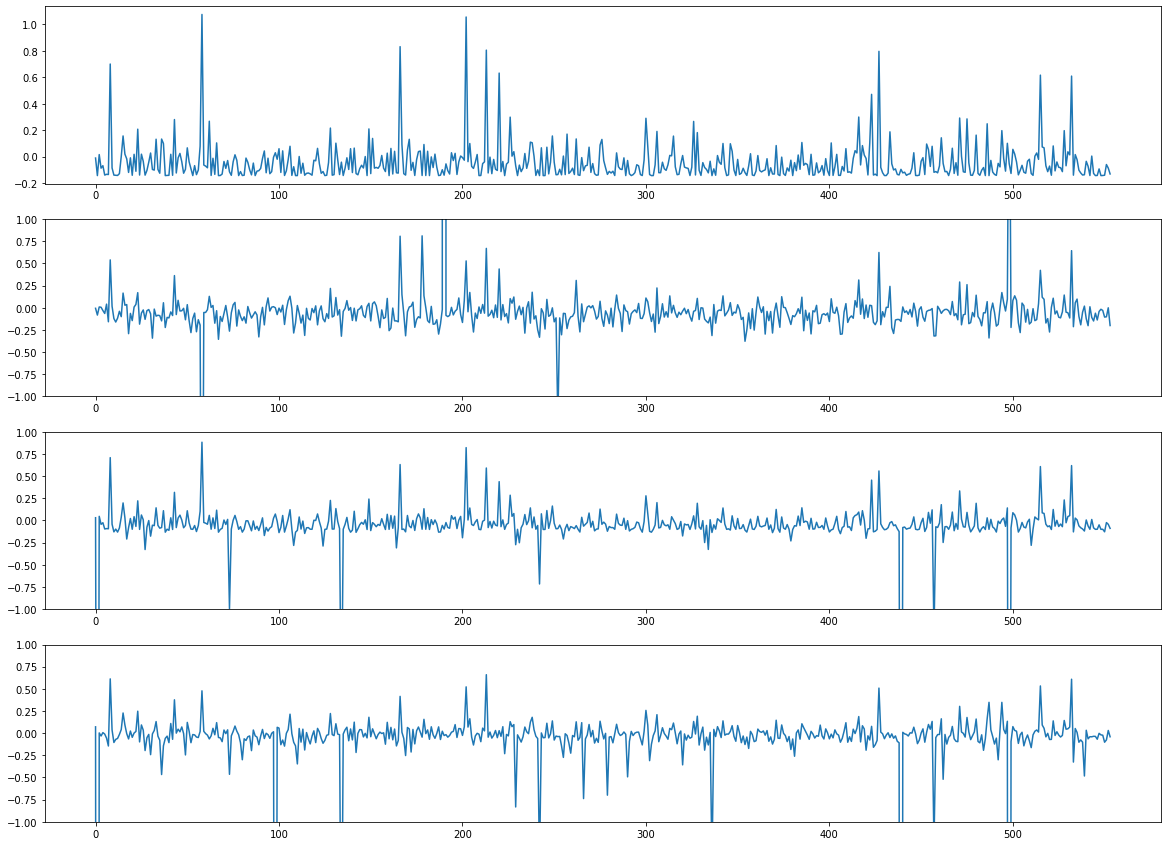

In [216]:
numpy_data = np.append(y_tests, reg_preds)
numpy_data = np.append(numpy_data, RFR_preds)
numpy_data = np.append(numpy_data, GBR_preds)
numpy_data = numpy_data.reshape(-1,4,order='F')
resultss = pd.DataFrame(data=numpy_data, index=np.arange(0,len(y_test))) 
resultss.columns = ['y_true', 'reg', 'RFR', 'GBR']
fig, ax = plt.subplots(4,1, figsize = (20,15)) #, sharey=True
ax[0].plot(resultss.index, resultss.y_true)
ax[1].plot(resultss.index, resultss.y_true-resultss.reg)
ax[2].plot(resultss.index, resultss.y_true-resultss.RFR)
ax[3].plot(resultss.index, resultss.y_true-resultss.GBR)
#ax[0].set_ylim([0,500000])
ax[1].set_ylim([-1,1])
ax[2].set_ylim([-1,1])
ax[3].set_ylim([-1,1])

(-300000, 300000)

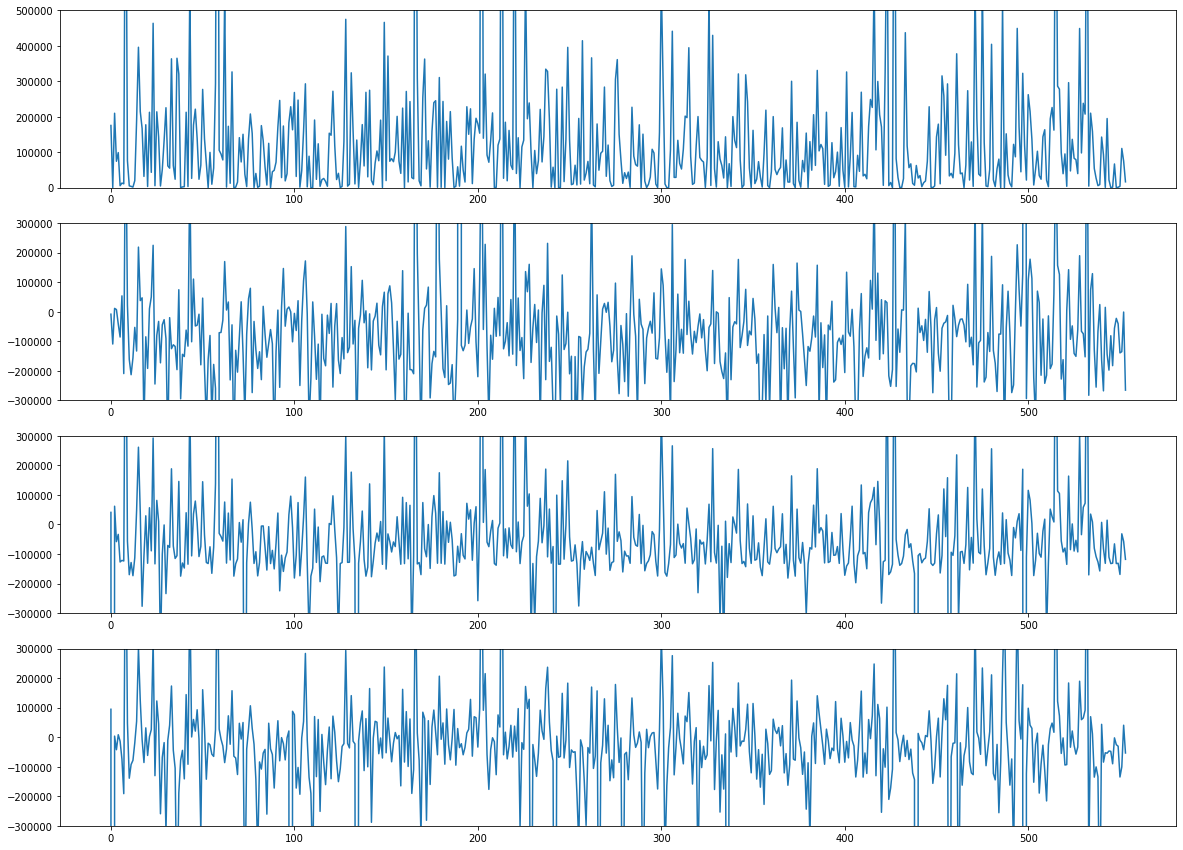

In [233]:
reg_preds_source = scaler_y.inverse_transform(reg_preds)
RFR_preds_source = scaler_y.inverse_transform(RFR_preds)
GBR_preds_source = scaler_y.inverse_transform(GBR_preds)

fig, ax = plt.subplots(4,1, figsize = (20,15)) #, sharey=True
ax[0].plot(results.index, results.y_true)
ax[1].plot(results.index, results.y_true.to_numpy().reshape(-1,1)-reg_preds_source)
ax[2].plot(results.index, results.y_true.to_numpy()-RFR_preds_source)
ax[3].plot(results.index, results.y_true.to_numpy()-GBR_preds_source)
ax[0].set_ylim([0,500000])
ax[1].set_ylim([-300000,300000])
ax[2].set_ylim([-300000,300000])
ax[3].set_ylim([-300000,300000])

In [ ]:
y_tests